# ClusterAI 2023

# Ciencia de Datos - Ingeniería Industrial - UTN BA

# clase_10: Practica Redes Neuronales

### Elaborado por: Aguirre Nicolas

# IMPORTS

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import seaborn
pd.set_option('display.float_format', lambda x: '%.1d' % x) # Para acotar los decimales en pandas

PyTorch

In [3]:
import torch
print('Version de Pytorch: ',torch.__version__)
import torchvision
import torchvision.transforms as transforms

import torch.nn as nn
import torch.nn.functional as F
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

Version de Pytorch:  2.1.0
cuda


In [4]:
# Primero cargamos los datos que ya vienen incluidos en la libreria sk-learn.
from torchvision.datasets import MNIST, FashionMNIST
# FashionMNIST
# https://github.com/zalandoresearch/fashion-mnist

In [ ]:
# transforms (tensor y normalization)
transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.2861), (0.3528))])

# datasets
trainset = torchvision.datasets.FashionMNIST('./data',
    download=True,
    train=True,
    transform=transform)
testset = torchvision.datasets.FashionMNIST('./data',
    download=True,
    train=False,
    transform=transform)

pytorch_batch_size = 32
# dataloaders
train_dl = torch.utils.data.DataLoader(trainset, batch_size=pytorch_batch_size,
                                        shuffle=True, num_workers=2)


val_dl = torch.utils.data.DataLoader(testset, batch_size=pytorch_batch_size,
                                        shuffle=False, num_workers=2)

# constant for classes
classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
        'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot')

map_dict = {0: 'T-shirt/top',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle Boot'}

In [6]:
# Generamos un iterador
dataiter = iter(train_dl)
# Le pedimos el proximo "batch"
images, labels = next(dataiter)

In [ ]:
# Veamos la primera sample
print(f'X: {images[0]}')
print(f'Y: \n{labels[0]} | class: {classes[labels[0]]} ')

In [8]:
# Funcion para mostrar imagenes
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

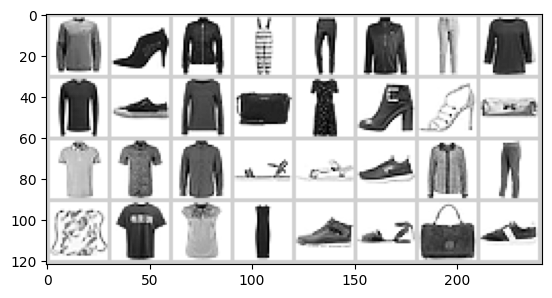

In [9]:
# Generamos un iterador
dataiter = iter(train_dl)
# Le pedimos el proximo "batch"
images, labels = next(dataiter)

# Para plot en grilla
img_grid = torchvision.utils.make_grid(images, nrow= int(pytorch_batch_size/4))

# Show images
matplotlib_imshow(img_grid, one_channel=True)

In [ ]:
# Dimensiones
print(images.size())
b,c,h,w = images.size() # batch, channels (1=Mono,  3 = RGB), height, width

torch.Size([32, 1, 28, 28])


In [ ]:
n_features = h * w
n_classes = len(classes)
print(f'Features: ',n_features)
print(f'Classes: ',n_classes)

Features:  784
Classes:  10


# Modelo

## Modelo

Al igual que TensorFlow-Keras, PyTorch es una libreria para codear modelos de NN y tambien tiene su modelo Sequential.

Pero a diferencia de TF-Keras, PyTorch no tiene nativamente las funciones **`fit`**, **`evaluate`** y **`predic`**.

Por lo cual somos nosotros quienes vamos a tener codear el entrenamiento ...

El tipo de arquitectura que vamos a utilizar es una NN fully-conected. Para esto utilizaremos la funcion `nn.Sequential()` a la cual le pasaremos los distintos componentes de la red.

Cuando usamos una arquitectura secuencial, vamos construyendo el **`forward` pass** de la red de manera tal que la red utiliza la salida de la capa inmediatamente anterior $z^{l-1}$ en la capa siguiente $z^{l}$, y asi sucecivamente hasta llegar al ultimo elemento de la red con el cual generamos el output.

$$
z^{l} = \sigma(Wz^{l-1}+b)
$$

Puntualmente, en este ejemplo utilizaremos unicamente dos componentes.

* [**nn.Linear**](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html#torch.nn.Linear) : Para aplicar la transformacion lineal $\delta = Wx + b$,
donde $\delta$ es llamada tambien *pre-activacion* de la neurona.

* [**nn.Sigmoid**](https://pytorch.org/docs/stable/generated/torch.nn.Sigmoid.html) : Para aplicar la funcion $\sigma(\delta) = \frac{1}{1 + \exp(-\delta)}$

En donde $W$ son los pesos (weights) que aprendera la red.


Cada una de las capas de nn.Linear se construye dandole la informacion de la cantidad de features de entrada y de salida. Como en nuestro ejemplo tenemos 3 clases de flores, la ultima capa debera tener una salida de dimension = 3.

<img src="NN.jpg" width="1200">

In [ ]:
class Red_Neuronal_Personalizada(nn.Module):
    def __init__(self, dims:list, activacion:str='relu'):
        super(Red_Neuronal_Personalizada, self).__init__()
        # Creamos unos lista para ir juntando cada element de la red
        layers = []
        # Vamos a iterar desde el primer elemento, hasta el anteultimo
        for i, d in enumerate(dims[:-1]):
            # Capas Dense / Linear
            # Dim de entrada
            dim_input = d
            # Dim de salida
            # (si hubieramos iterado hasta el ultimo elemento no se podria acceder a i+1)
            dim_output = dims[i+1]
            layers.append(nn.Linear(dim_input, dim_output))
            # Funciones de activacion
            if activacion =='relu':
                layers.append(nn.ReLU())
            elif activacion == 'sigmoid':
                layers.append(nn.Sigmoid())
            else:
                raise ValueError("Solo 'relu' y 'sigmoid' son activaciones valuadas")

        # "desempacamos" la variable layers dentro de nn.Sequential()
        self.network = nn.Sequential(*layers)
        print(self.network)
    def forward(self, x):
        output = self.network(x)
        return output

In [ ]:
input_features = n_features
output_dim = len(classes)
dims = [input_features, 128, 64, 32,  output_dim]


In [ ]:
modelo = Red_Neuronal_Personalizada(dims, activacion = 'sigmoid')

Sequential(
  (0): Linear(in_features=784, out_features=128, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=128, out_features=64, bias=True)
  (3): Sigmoid()
  (4): Linear(in_features=64, out_features=32, bias=True)
  (5): Sigmoid()
  (6): Linear(in_features=32, out_features=10, bias=True)
  (7): Sigmoid()
)


## Optimizador y Loss function

In [ ]:
# Learning rate y Optimizador
lr = 0.01
optimizador = torch.optim.SGD(modelo.parameters(),lr=lr, weight_decay=0.001)
# Funcion de penalizacion
loss_func = nn.CrossEntropyLoss()

<img src="NN_Flow.jpg" width="1200">

## Training

En este punto ya contamos con todas las "herramientras" que necesitamos para entrenar un modelo de NN.

* Datos
* Optimizador
* Funcion de Penalizacion
* Red Neuronal

Vamos a ver como es que esto elementos "interactuan" para actualizar los parametros/*weights* de la Red Neuronal ... es decir ... para entrenarla.

![](https://drive.google.com/uc?id=1d7Rq5FsmQNWcP8T1KGi_TodL49jCEKnY)

In [ ]:
# Cantidad de Epochs
n_epochs = 20

# Generamos un diccionario donde vamos a guaradr historial de entrenamiento
training = {'train':{'loss':[],
                    'acc':[]},
           'val':{'loss':[],
                  'acc':[]}
           }

In [ ]:
################################################
# TRAINING: Epochs
################################################
for epoch in range(n_epochs):
  # Ahora nosotros vamos a tener que definir estas variables ...
  train_loss = 0
  cls_correctas_train = 0
  train_acc = 0
  ################################################
  # TRAINING: Batch
  ################################################
  for i , (x_batch, y_batch) in enumerate(train_dl):
    # Limpiamos todos los gradientes cargados en el optimizador
    optimizador.zero_grad()
    # fix shapes
    b,c, h, w = x_batch.size()
    x_batch = torch.reshape(x_batch, shape=(b,h*w))
    # Con un x_batch generamos una prediccion
    y_pred = modelo(x_batch)
    # La clase predicha será el índice de máximo valor luego del
    # softmax (integrado en CrossEntropyLoss)
    _, predicted = torch.max(y_pred.data, 1)
    # Calculamos la loss
    batch_loss = loss_func(y_pred,y_batch)
    # Calculamos el gradiente de la loss
    # Aca es donde sucede el back-propagation a.k.a. "la magia"
    batch_loss.backward()
    # Ajustamos los parametros del modelo con el optimizador
    optimizador.step()
    # Acumulamos la loss
    train_loss += batch_loss.item()
    # Sumamos la cantidad de clases correctas en el batch
    correct_i = (predicted == y_batch).sum().item()
    # Acumulamos corrects
    cls_correctas_train += correct_i

  ################################################
  # TRAINING: Validation
  ################################################
  val_loss = 0
  cls_correctas_val = 0
  val_acc = 0
  with torch.torch.inference_mode():
    for x_batch, y_batch in val_dl:
      # fix shapes
      b,c, h, w = x_batch.size()
      x_batch = torch.reshape(x_batch, shape=(b,h*w))
      y_pred = modelo(x_batch)
      _, predicted = torch.max(y_pred.data, 1)
      batch_loss = loss_func(y_pred,y_batch)
      val_loss += batch_loss.item()
      correct_i = (predicted == y_batch).sum().item()
      cls_correctas_val += correct_i

  # Calculamos el accuracy
  train_acc = (cls_correctas_train / len(trainset))*100    # Calculamos el accuracy
  val_acc = (cls_correctas_val / len(testset))*100
  mean_train_loss = train_loss/len(trainset)
  mean_val_loss = val_loss/len(testset)

  # Imprimimos en pantalla
  print('Epoch: {} T_Loss: {:.4f} T_Acc: {:.2f}%  V_Loss: {:.4f} V_Acc: {:.2f} %'.format(
      epoch,mean_train_loss,train_acc,mean_val_loss,val_acc))

  # Guardamos en el historial de entrenamiento ...
  training['train']['loss'].append(mean_train_loss)
  training['train']['acc'].append(train_acc)
  training['val']['loss'].append(mean_val_loss)
  training['val']['acc'].append(val_acc)

Epoch: 0 T_Loss: 0.0720 T_Acc: 9.97%  V_Loss: 0.0721 V_Acc: 10.00 %
Epoch: 1 T_Loss: 0.0720 T_Acc: 10.05%  V_Loss: 0.0721 V_Acc: 16.69 %
Epoch: 2 T_Loss: 0.0719 T_Acc: 10.76%  V_Loss: 0.0721 V_Acc: 22.68 %
Epoch: 3 T_Loss: 0.0719 T_Acc: 12.28%  V_Loss: 0.0721 V_Acc: 21.01 %
Epoch: 4 T_Loss: 0.0719 T_Acc: 12.16%  V_Loss: 0.0720 V_Acc: 24.45 %
Epoch: 5 T_Loss: 0.0719 T_Acc: 14.58%  V_Loss: 0.0720 V_Acc: 14.94 %
Epoch: 6 T_Loss: 0.0719 T_Acc: 14.15%  V_Loss: 0.0720 V_Acc: 20.05 %
Epoch: 7 T_Loss: 0.0719 T_Acc: 13.27%  V_Loss: 0.0720 V_Acc: 35.09 %
Epoch: 8 T_Loss: 0.0719 T_Acc: 16.08%  V_Loss: 0.0720 V_Acc: 20.01 %
Epoch: 9 T_Loss: 0.0719 T_Acc: 14.47%  V_Loss: 0.0720 V_Acc: 28.20 %
Epoch: 10 T_Loss: 0.0719 T_Acc: 15.61%  V_Loss: 0.0720 V_Acc: 17.19 %
Epoch: 11 T_Loss: 0.0719 T_Acc: 17.19%  V_Loss: 0.0720 V_Acc: 19.55 %
Epoch: 12 T_Loss: 0.0719 T_Acc: 19.69%  V_Loss: 0.0720 V_Acc: 13.89 %
Epoch: 13 T_Loss: 0.0719 T_Acc: 20.05%  V_Loss: 0.0720 V_Acc: 27.73 %
Epoch: 14 T_Loss: 0.0718 T_Acc:

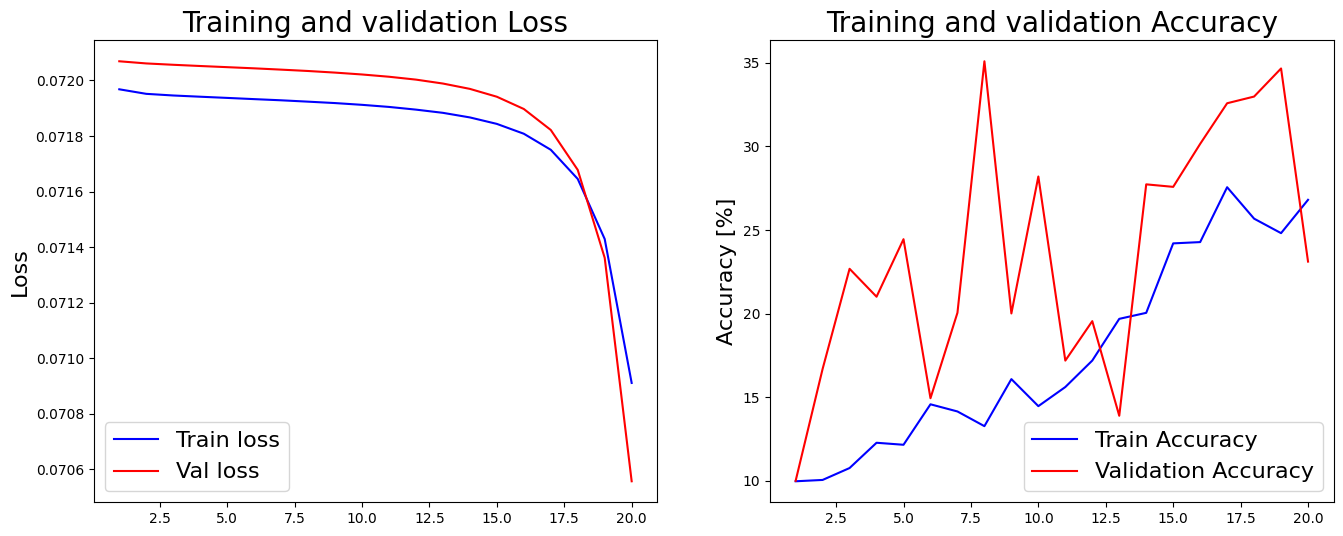

In [ ]:
#Loss
train_loss_h = training['train']['loss']
val_loss_h = training['val']['loss']
# Acc
train_acc_h = training['train']['acc']
val_acc_h = training['val']['acc']
lepochs = range(1, len(train_loss_h) + 1)

fig,(axs1,axs2) = plt.subplots(1,2,figsize=(16,6))
axs1.plot(lepochs, train_loss_h, 'b', label='Train loss')
axs1.plot(lepochs, val_loss_h, 'r', label='Val loss')
axs1.set_title('Training and validation Loss',fontsize=20)
axs1.set_ylabel('Loss',fontsize=16)
axs1.legend(fontsize=16)
axs2.plot(lepochs, train_acc_h, 'b', label='Train Accuracy')
axs2.plot(lepochs, val_acc_h, 'r', label='Validation Accuracy')
axs2.set_title('Training and validation Accuracy',fontsize=20)
axs2.set_ylabel('Accuracy [%]',fontsize=16)
axs2.legend(fontsize=16)
plt.show()

Analisis ...

# Parte II

In [ ]:
def func_train(model, train_dl, train_ds, loss_func, optimizador):
  train_loss = 0
  cls_correctas_train = 0
  train_acc = 0
  ################################################
  # TRAINING
  ################################################
  for i , (x_batch, y_batch) in enumerate(train_dl):
    # fix shapes
    b,c, h, w = x_batch.size()
    x_batch = torch.reshape(x_batch, shape=(b,h*w))
    # Limpiamos todos los gradientes cargados en el optimizador
    optimizador.zero_grad()
    # Con un x_batch generamos una prediccion
    y_pred = model(x_batch)
    # La clase predicha será el índice de máximo valor luego del
    # softmax (integrado en CrossEntropyLoss)
    _, predicted = torch.max(y_pred.data, 1)
    # Calculamos la loss
    batch_loss = loss_func(y_pred,y_batch)
    # Calculamos el gradiente de la loss
    # Aca es donde sucede el back-propagation a.k.a. "la magia"
    batch_loss.backward()
    # Ajustamos los parametros del modelo con el optimizador
    optimizador.step()
    # Acumulamos la loss
    train_loss += batch_loss.item()
    # Sumamos la cantidad de clases correctas en el batch
    correct_i = (predicted == y_batch).sum().item()
    # Acumulamos corrects
    cls_correctas_train += correct_i
  # Calculamos el accuracy
  train_acc = (cls_correctas_train / len(train_ds))*100    # Calculamos el accuracy
  mean_train_loss = train_loss/len(train_ds)

  return (model, mean_train_loss,  cls_correctas_train,  train_acc)

In [ ]:
def func_validation(model, val_dl, val_ds, loss_func):
  val_loss = 0
  cls_correctas_val = 0
  val_acc = 0
  ################################################
  # VALIDATION
  ################################################
  with torch.torch.inference_mode():
    for x_batch, y_batch in val_dl:
      # fix shapes
      b,c, h, w = x_batch.size()
      x_batch = torch.reshape(x_batch, shape=(b,h*w))
      y_pred = model(x_batch)
      _, predicted = torch.max(y_pred.data, 1)
      batch_loss = loss_func(y_pred,y_batch)
      val_loss += batch_loss.item()
      correct_i = (predicted == y_batch).sum().item()
      cls_correctas_val += correct_i
  # Calculamos el accuracy
  val_acc = (cls_correctas_val / len(val_ds))*100
  mean_val_loss = val_loss/len(val_ds)
  return (mean_val_loss, cls_correctas_val, val_acc)

In [ ]:
def func_fit(n_epochs, model,
             train_ds, val_ds, pytorch_batch_size,
             loss_func, optimizador):


  # dataloaders
  train_dl = torch.utils.data.DataLoader(train_ds, batch_size=pytorch_batch_size,
                                            shuffle=True, num_workers=2)


  val_dl = torch.utils.data.DataLoader(val_ds, batch_size=pytorch_batch_size,
                                            shuffle=False, num_workers=2)


  # Generamos un diccionario donde vamos a guaradr historial de entrenamiento
  training = {'train':{'loss':[],
                      'acc':[]},
            'val':{'loss':[],
                    'acc':[]}
            }
  # For loop epochs
  for epoch in range(n_epochs):
    model, train_loss, cls_correctas_train, train_acc =  func_train(model, train_dl, train_ds, loss_func, optimizador)
    val_loss, cls_correctas_val, val_acc = func_validation(model, val_dl, val_ds, loss_func)
    # Imprimimos en pantalla
    print('Epoch: {} T_Loss: {:.4f} T_Acc: {:.2f}%  V_Loss: {:.4f} V_Acc: {:.2f} %'.format(
        epoch,train_loss,train_acc,val_loss,val_acc))

    # Guardamos en el historial de entrenamiento ...
    training['train']['loss'].append(train_loss)
    training['train']['acc'].append(train_acc)
    training['val']['loss'].append(val_loss)
    training['val']['acc'].append(val_acc)
  return (model, training)

## Definicion de nuevos parametros

In [ ]:
# Learning rate y Optimizador
lr = 0.001
# pytorch_batch_size
pytorch_batch_size = 32
# Cantidad de Epochs a entrenar
n_epochs = 20
# Dimensiones
dims = [input_features, 128, 64, 32, output_dim]
# Activacion
activacion = 'relu'

In [ ]:
# Modelo
nuevo_modelo = Red_Neuronal_Personalizada(dims, activacion=activacion)
# Optimizador
optimizador = torch.optim.SGD(nuevo_modelo.parameters(),lr=lr,  weight_decay=0.001)
# Funcion de penalizacion
loss_func = nn.CrossEntropyLoss()


Sequential(
  (0): Linear(in_features=784, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=32, bias=True)
  (5): ReLU()
  (6): Linear(in_features=32, out_features=10, bias=True)
  (7): ReLU()
)


## Fit

In [ ]:
nuevo_modelo, training = func_fit(n_epochs, nuevo_modelo, trainset, testset, pytorch_batch_size, loss_func, optimizador)

Epoch: 0 T_Loss: 0.0705 T_Acc: 28.34%  V_Loss: 0.0679 V_Acc: 38.33 %
Epoch: 1 T_Loss: 0.0583 T_Acc: 45.11%  V_Loss: 0.0459 V_Acc: 59.53 %
Epoch: 2 T_Loss: 0.0382 T_Acc: 63.12%  V_Loss: 0.0338 V_Acc: 64.87 %
Epoch: 3 T_Loss: 0.0309 T_Acc: 67.57%  V_Loss: 0.0297 V_Acc: 68.16 %
Epoch: 4 T_Loss: 0.0282 T_Acc: 69.17%  V_Loss: 0.0279 V_Acc: 69.13 %
Epoch: 5 T_Loss: 0.0268 T_Acc: 70.28%  V_Loss: 0.0270 V_Acc: 69.82 %
Epoch: 6 T_Loss: 0.0259 T_Acc: 71.15%  V_Loss: 0.0264 V_Acc: 70.21 %
Epoch: 7 T_Loss: 0.0252 T_Acc: 71.89%  V_Loss: 0.0255 V_Acc: 71.10 %
Epoch: 8 T_Loss: 0.0246 T_Acc: 72.48%  V_Loss: 0.0250 V_Acc: 71.51 %
Epoch: 9 T_Loss: 0.0240 T_Acc: 73.15%  V_Loss: 0.0245 V_Acc: 72.07 %
Epoch: 10 T_Loss: 0.0235 T_Acc: 73.65%  V_Loss: 0.0241 V_Acc: 72.61 %
Epoch: 11 T_Loss: 0.0231 T_Acc: 74.02%  V_Loss: 0.0236 V_Acc: 73.00 %
Epoch: 12 T_Loss: 0.0227 T_Acc: 74.43%  V_Loss: 0.0233 V_Acc: 73.41 %
Epoch: 13 T_Loss: 0.0223 T_Acc: 74.78%  V_Loss: 0.0230 V_Acc: 73.73 %
Epoch: 14 T_Loss: 0.0220 T_Acc

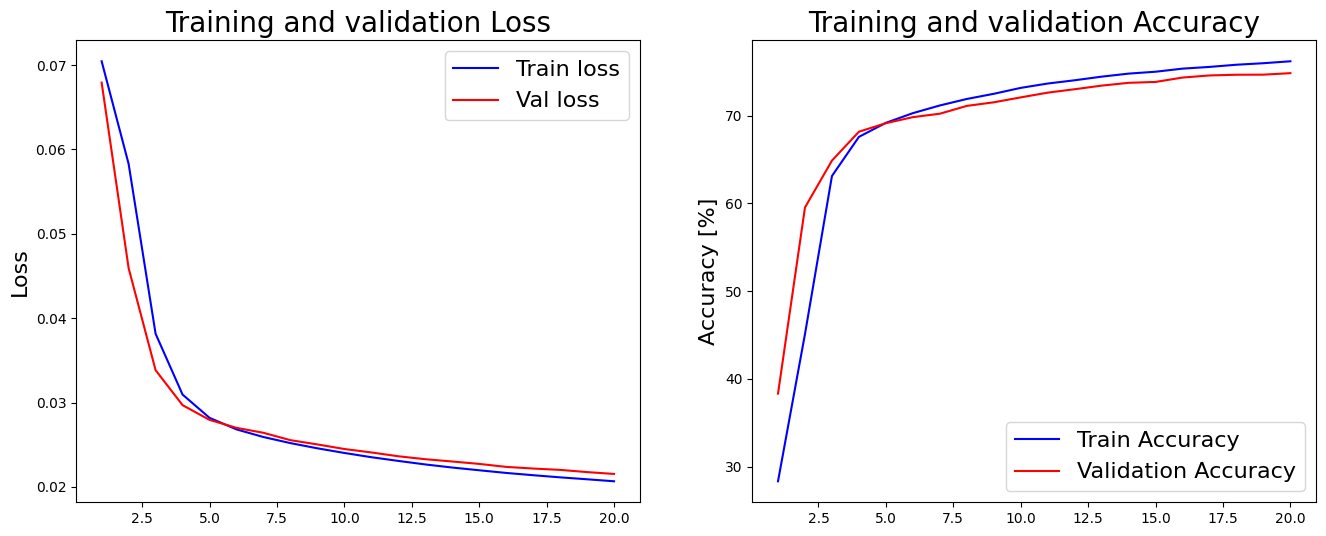

In [ ]:
#Loss
train_loss_h = training['train']['loss']
val_loss_h = training['val']['loss']
# Acc
train_acc_h = training['train']['acc']
val_acc_h = training['val']['acc']
lepochs = range(1, len(train_loss_h) + 1)

fig,(axs1,axs2) = plt.subplots(1,2,figsize=(16,6))
axs1.plot(lepochs, train_loss_h, 'b', label='Train loss')
axs1.plot(lepochs, val_loss_h, 'r', label='Val loss')
axs1.set_title('Training and validation Loss',fontsize=20)
axs1.set_ylabel('Loss',fontsize=16)
axs1.legend(fontsize=16)
axs2.plot(lepochs, train_acc_h, 'b', label='Train Accuracy')
axs2.plot(lepochs, val_acc_h, 'r', label='Validation Accuracy')
axs2.set_title('Training and validation Accuracy',fontsize=20)
axs2.set_ylabel('Accuracy [%]',fontsize=16)
axs2.legend(fontsize=16)
plt.show()

In [ ]:
def func_proyecciones(model, dataset, pytorch_batch_size):
  ################################################
  # Obtener embbedings/proyecciones/feature speace
  ################################################
  dataloader = torch.utils.data.DataLoader(dataset, batch_size=pytorch_batch_size,
                                        shuffle=False, num_workers=2)
  # Obtengamos las unuestra red hasta el anteultimo output
  pre_output = model.network[:-2]
  n_features = pre_output[-2].out_features
  n_sampes = len(dataset)
  x_proy = torch.zeros((n_sampes,n_features),dtype=int)
  y = np.zeros((n_sampes))
  pos_init = 0
  pos_final = 0
  with torch.torch.inference_mode():
    for x_batch, y_batch in dataloader:
      b, c, h, w = x_batch.size()
      pos_final = pos_init + b
      # fix shapes
      x_batch = torch.reshape(x_batch, shape=(b,h*w))
      x_batch_proy = pre_output(x_batch)
      x_proy[pos_init:pos_final] = x_batch_proy
      y[pos_init:pos_final] = y_batch.cpu().numpy()

  #convertimos a numpy
  x_proy = x_proy.cpu().numpy()
  return x_proy, y.astype(int)

In [ ]:
x_proy, y = func_proyecciones(nuevo_modelo, testset, pytorch_batch_size=200 )


In [ ]:
np.shape(x_proy)

(10000, 32)

## TNSE

In [ ]:
X_tsne = TSNE(n_components=2, learning_rate=20, init="pca", perplexity=6, verbose=1).fit_transform(x_proy)
X_tsne.shape

[t-SNE] Computing 19 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.002s...
[t-SNE] Computed neighbors for 10000 samples in 1.109s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 53.547890
[t-SNE] KL divergence after 1000 iterations: 0.031408


(10000, 2)

Ahora vamos a juntar los `x`con los labes y las clases dentro de un Dataframe

In [ ]:
tsne_join = np.concatenate((X_tsne,y[...,np.newaxis]),axis=1, dtype=float)
tsne_df = pd.DataFrame(tsne_join,  columns=["x1", "x2","y"])
tsne_df['class'] = tsne_df['y'].map(map_dict)
tsne_df

,x1,x2,y,class
0,37,-9,8,Bag
1,43,1,3,Dress
2,35,22,1,Trouser
3,38,-14,8,Bag
4,-41,10,7,Sneaker
...,...,...,...,...
9995,0,0,0,T-shirt/top
9996,0,0,0,T-shirt/top
9997,0,0,0,T-shirt/top
9998,0,0,0,T-shirt/top


### Plot

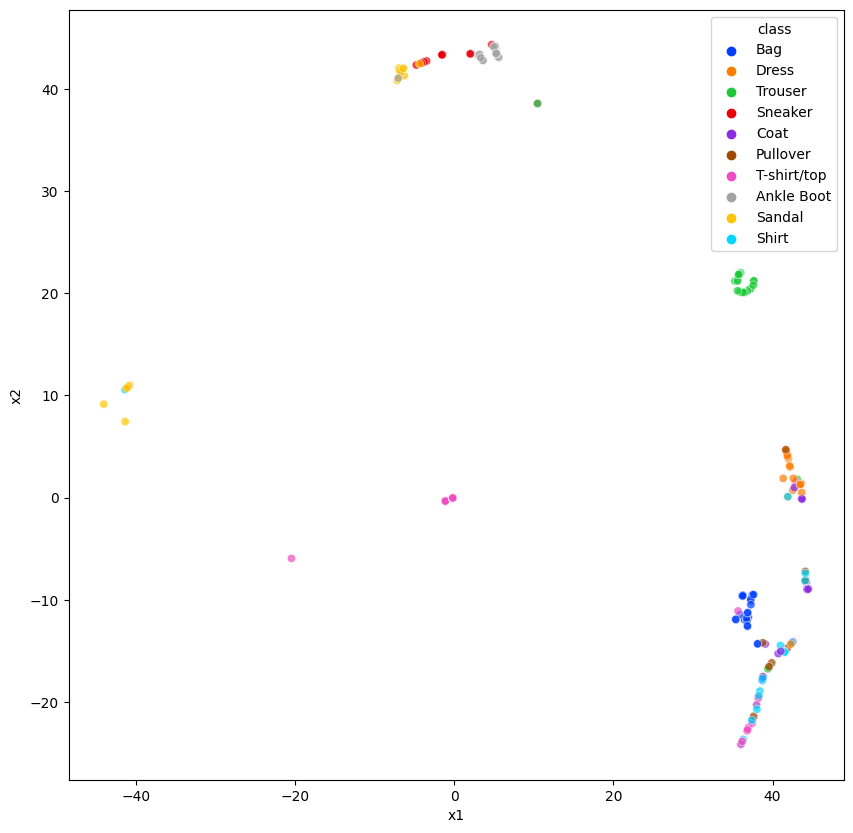

In [ ]:
plt.figure(figsize=(10,10))
seaborn.scatterplot(data=tsne_df,x="x1", y="x2", hue='class', alpha=0.7, palette='bright')
plt.show()

## PCA

In [ ]:
X_pca = PCA(n_components=2, ).fit_transform(x_proy)
X_pca.shape

(10000, 2)

In [ ]:
pca_join = np.concatenate((X_pca,y[...,np.newaxis]),axis=1, dtype=float)
pca_df = pd.DataFrame(pca_join,  columns=["x1", "x2","y"])
pca_df['class'] = pca_df['y'].map(map_dict)
pca_df

,x1,x2,y,class
0,15,0,8,Bag
1,28,2,3,Dress
2,18,11,1,Trouser
3,9,0,8,Bag
4,1,1,7,Sneaker
...,...,...,...,...
9995,0,0,0,T-shirt/top
9996,0,0,0,T-shirt/top
9997,0,0,0,T-shirt/top
9998,0,0,0,T-shirt/top


### Plot

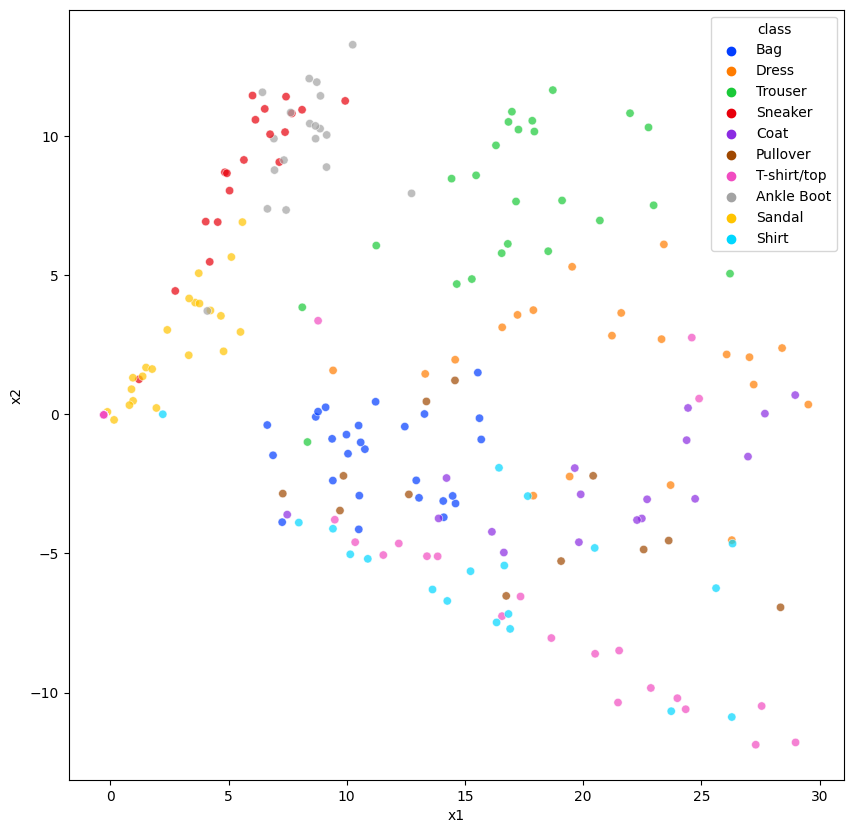

In [ ]:
plt.figure(figsize=(10,10))
seaborn.scatterplot(data=pca_df,x="x1", y="x2", hue='class', alpha=0.7, palette='bright')
plt.show()